<h1 align="center">Text Summarization Using BART and T5 Models</h1>

## Project Goal

In this project, I focus on **text summarization using BART and T5 models on the CNN/Daily Mail Dataset**.

I use 6 different pre-trained models provided by Hugging Face and re-train them on the specified dataset for better performance. I mainly investigate three aspects:

- (1) First, how do the pre-trained models initially perform on the CNN/Daily Mail dataset?

- (2) Second, what techniques can we use during the training process to re-train large language models (LLMs) on a relatively small dataset?

- (3) Third, how do different models react to the training process, and what are their performances after the training?

In addition, I investigate the effectiveness of two advanced fine-tuning techniques including layer freezing and discriminative fine-tuning.

## Table of Contents

>>[Set Up Environment](#scrollTo=7kRB5arLnOcg)

>>[Import Libraries](#scrollTo=OkCLSmfFnShw)

>>[Define Constants](#scrollTo=ARUdJzqKngl1)

>>[Load CNN/Daily Mail Dataset](#scrollTo=_k0jITnCnW5d)

>>[Load Pre-trained Models](#scrollTo=03W21c-wnpcK)

>>[Text Preprocessing](#scrollTo=ZIx9E7fJzDYf)

>>[Save Tokenized Dataset](#scrollTo=jfDXu_XjOJny)

>>[Load Tokenized Dataset](#scrollTo=eHfyMCK9OVX4)

>>[Data Visualization](#scrollTo=nnhjOAWvOm7v)

>>>[9.1 Build Pandas DataFrame](#scrollTo=p7quoYypPmwk)

>>>[9.2 Word Cloud](#scrollTo=1B-qfyT6Pq2i)

>>>[9.3 Top 20 Common Tokens](#scrollTo=WINYmE5wS8qF)

>>>[9.4 Distribution of Article Lengths](#scrollTo=dKP7pTyya1y1)

>>>[9.5 Distribution of Summary Lengths](#scrollTo=gcCAu5ZOd2CS)

>>>[9.6 Article Summary Lengths Comparison](#scrollTo=Pfw-YJ53R_sM)

>>[Qualitative Analysis](#scrollTo=pA5Apl9VTMoN)



## 1. Set Up Environment

In [1]:
!pip install torch datasets transformers rouge-score

In [2]:
! pip install -U accelerate
! pip install -U transformers

## 2. Import Libraries

In [3]:
from google.colab import drive
drive.mount("/content/drive")

import fileinput
import sys
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch
import datasets
from datasets import load_dataset, load_metric, Dataset
from datasets import load_from_disk
from transformers import BartTokenizer, BartForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration
from transformers import Trainer, TrainingArguments
from transformers import pipeline

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from collections import Counter
from wordcloud import WordCloud
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display

## 3. Define Constants

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
data_dir = "./"

## 4. Load CNN/Daily Mail Dataset

The CNN/Daily Mail dataset is one of the most popular datasets in the NLP field for text summarization tasks.

- It contains 311971 long articles from CNN and Daily Mail.

- Each article has a corresponding summary written by real people.

In [9]:
dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:10%]")

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

## 5. Load Pre-trained Models

- BART is a Seq-to-Seq model consisting of a bidirectional encoder inherited from BERT and an autoregressive decoder inspired by GPT.

- T5 is a transformer-based Text-To-Text model. The spotlight of this model is its versatile ability due to its text-based input and output.

In this project, I experiment with 6 different variations of the BART and T5 models.

| Model Name | Model Label | Model Description |
| ---        | ---         | ---               |
| BART-BASE         | facebook/bart-base | BART base version. |
| BART-LARGE        | facebook/bart-large | BART large version with more learnable parameters and better performance. |
| BART-LARGE-CNN    | facebook/bart-large-cnn | BART large version that has been fine-tuned for text summarization on the CNN/Daily Mail dataset. |
| T5-SMALL          | t5-small | T5 small version. |
| T5-BASE           | t5-base | T5 base version. |
| T5-LARGE          | t5-large | T5 large version with more learnable parameters and better performance. |

The details of the six selected models are as follows.

| Model | Layers | Attention Heads | Hidden Size | Number of Parameters | Vocabulary Size |
| --- | --- | --- | --- | --- | --- |
| BART-BASE         | 12 | 12 | 768 | 139M | 50265 |
| BART-LARGE        | 12 | 16 | 1024 | 406M | 50265 |
| BART-LARGE-CNN    | 12 | 16 | 1024 | 406M | 50265 |
| T5-SMALL          | 6 | 8 | 512 | 60M | 32128 |
| T5-BASE           | 12 | 12 | 768 | 220M | 32128 |
| T5-LARGE          | 24 | 16 | 1024 | 770M | 32128 |

In [10]:
# Initialize BART tokenizer
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

# Initialize T5 tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## 6. Text Preprocessing

In [11]:
if not os.path.exists(data_dir):
    # Tokenize the input text
    tokenized_dataset = bart_tokenizer(dataset["article"], padding=True, truncation=True, return_tensors="pt")

## 7. Save Tokenized Dataset

In [12]:
if not os.path.exists(data_dir):
    # Convert tokenized output to Dataset type
    save_tokenized_dataset = Dataset.from_dict(tokenized_dataset)

    # Save the tokenized dataset to the folder
    save_tokenized_dataset.save_to_disk(data_dir)

## 8. Load Tokenized Dataset

In [13]:
# Load the tokenized dataset from the folder
load_tokenized_dataset = load_from_disk(data_dir)
print(load_tokenized_dataset)

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 28711
})


## 9. Data Visualization

### 9.1 Build Pandas DataFrame

In [14]:
# Prepare data for visualization using Pandas
input_ids_list = load_tokenized_dataset["input_ids"]
all_token_ids = [token_id for sub_input_ids_list in input_ids_list for token_id in sub_input_ids_list]
token_frequency = Counter(all_token_ids)

In [15]:
df = pd.DataFrame(token_frequency.items(), columns=["token_id", "frequency"])
df["token"] = df["token_id"].apply(lambda x: bart_tokenizer.decode([x], skip_special_tokens=True).strip())
df = df.sort_values(by="frequency", ascending=False).reset_index(drop=True)

# Display sample data
df[:20]

,token_id,frequency,token
0,1,68584646,
1,5,906104,the
2,6,860220,","
3,4,840380,.
4,7,469706,to
5,9,422861,of
6,8,397035,and
7,10,391937,a
8,11,346875,in
9,22,234174,""""


### 9.2 Word Cloud

In this section, I use a word cloud to visualize the 200 most commonly used words in the dataset.

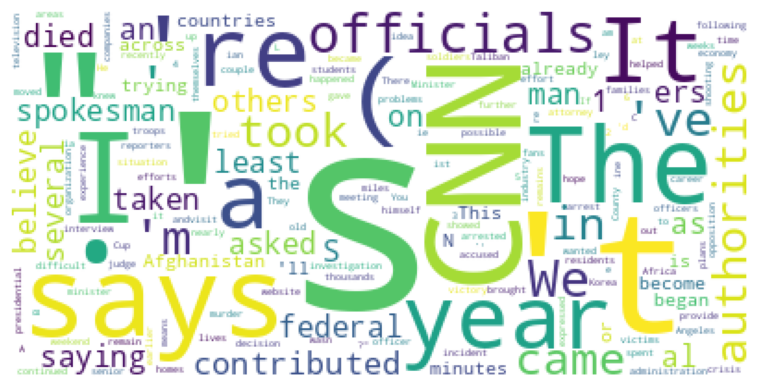

In [16]:
word_frequency = dict(zip(df["token"], df["frequency"]))

wordcloud = WordCloud(width=400,
                      height=200,
                      background_color='white',
                      min_font_size=5,
                      colormap="viridis"
                      ).generate_from_frequencies(word_frequency)

# Define object-oriented interface
fig, ax = plt.subplots(figsize=(8, 4))

ax.imshow(wordcloud)
ax.axis('off')

# Get ready to save the figure
fig.tight_layout()

### 9.3 Top 20 Common Tokens

In this section, I use a bar plot to visualize the top 20 common tokens in the dataset.

In [17]:
bar_tokens = []
bar_freq = []
flag_count = 0
for i in range(len(df["token"])):
    if flag_count >= 20:
        break
    if df["token"][i].isalpha():
        flag_count += 1
        bar_tokens.append(df.iloc[i]["token"])
        bar_freq.append(df.iloc[i]["frequency"])

bar_word_count = pd.DataFrame({"token": bar_tokens, "frequency": bar_freq})

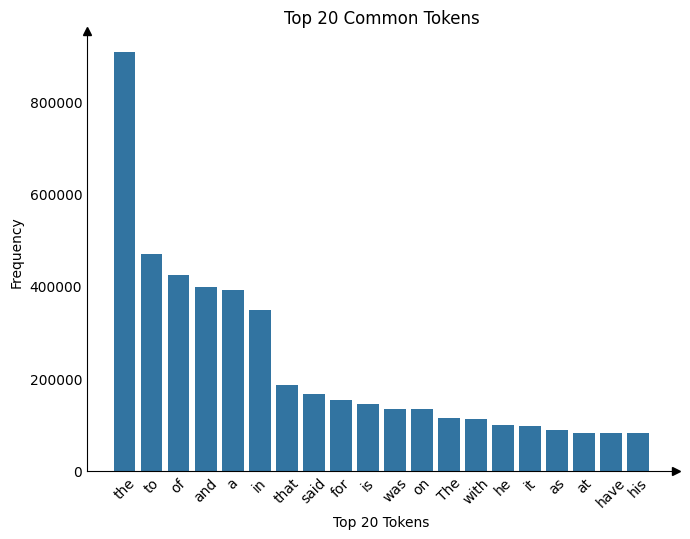

In [18]:
# Define object-oriented interface
fig, ax = plt.subplots(figsize=(7, 5.5))

sns.barplot(bar_word_count, x="token", y="frequency")
ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(length=0)

ax.spines[["right", "top"]].set_visible(False)

ax.plot(1, 0, ">k", transform=ax.transAxes, clip_on=False)
ax.plot(0, 1, "^k", transform=ax.transAxes, clip_on=False)

ax.set_title("Top 20 Common Tokens")
ax.set_xlabel("Top 20 Tokens")
ax.set_ylabel("Frequency")
ax.set_xticklabels(bar_tokens, rotation=45)

# Get ready to save the figure
fig.tight_layout()

### 9.4 Distribution of Article Lengths

In this section, I use histogram and kernel density estimation to visualize the distribution of article lengths. We can observe the range and trends of the lengths of the articles in the dataset.

In [19]:
article_word_counts = []

for article in dataset["article"]:
    word_count_pre_article = len(article.split())
    article_word_counts.append(word_count_pre_article)

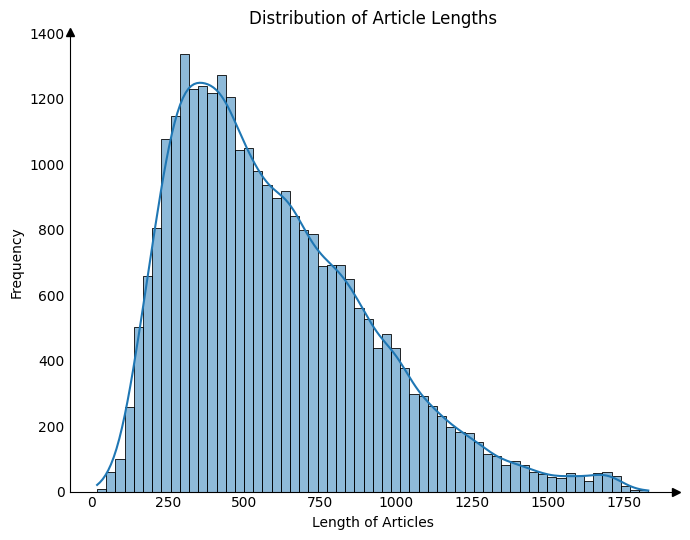

In [20]:
# Define object-oriented interface
fig, ax = plt.subplots(figsize=(7, 5.5))

sns.histplot(article_word_counts, bins=60, kde=True)
ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(length=0)

ax.spines[["right", "top"]].set_visible(False)

ax.plot(1, 0, ">k", transform=ax.transAxes, clip_on=False)
ax.plot(0, 1, "^k", transform=ax.transAxes, clip_on=False)

ax.set_title("Distribution of Article Lengths")
ax.set_xlabel("Length of Articles")
ax.set_ylabel("Frequency")

# Get ready to save the figure
fig.tight_layout()

### 9.5 Distribution of Summary Lengths

In this section, I use a box plot to visualize the distribution of summary lengths. We can observe the relations between median, quartiles, and outliers of the lengths of the summaries in the dataset.

In [21]:
summary_word_counts = []

for summary in dataset["highlights"]:
    word_count_pre_summary = len(summary.split())
    summary_word_counts.append(word_count_pre_summary)
summary_word_counts = pd.DataFrame(summary_word_counts, columns=["length"])

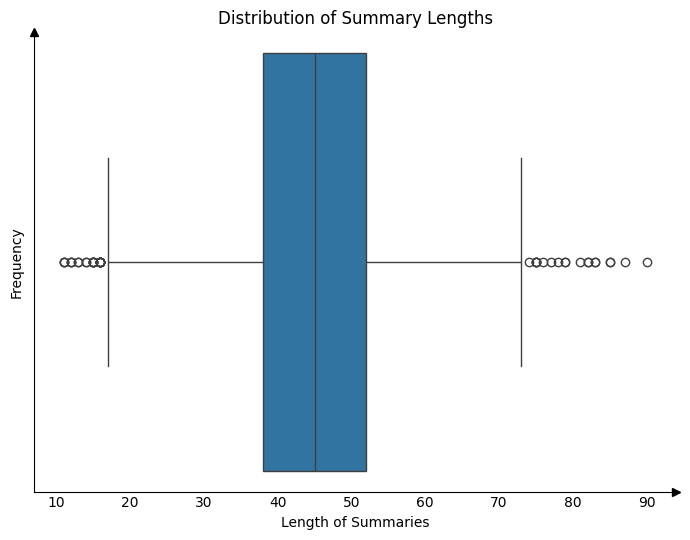

In [22]:
# Define object-oriented interface
fig, ax = plt.subplots(figsize=(7, 5.5))

sns.boxplot(x="length", data=summary_word_counts, showfliers=True)
ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(length=0)

ax.spines[["right", "top"]].set_visible(False)

ax.plot(1, 0, ">k", transform=ax.transAxes, clip_on=False)
ax.plot(0, 1, "^k", transform=ax.transAxes, clip_on=False)

ax.set_title("Distribution of Summary Lengths")
ax.set_xlabel("Length of Summaries")
ax.set_ylabel("Frequency")

# Get ready to save the figure
fig.tight_layout()

In [23]:
summary_word_counts.describe()

,length
count,28711.000000
mean,44.835986
std,9.206268
min,11.000000
25%,38.000000
50%,45.000000
75%,52.000000
max,90.000000


- Min sentence length: 11

- Lower quartile (Q1): 38

- Median sentence length: 45

- Upper quartile (Q3): 52

- Max sentence length: 90

### 9.6 Article Summary Lengths Comparison

In this section, I use a scatter plot to visualize the correlation between the length of articles and summaries.

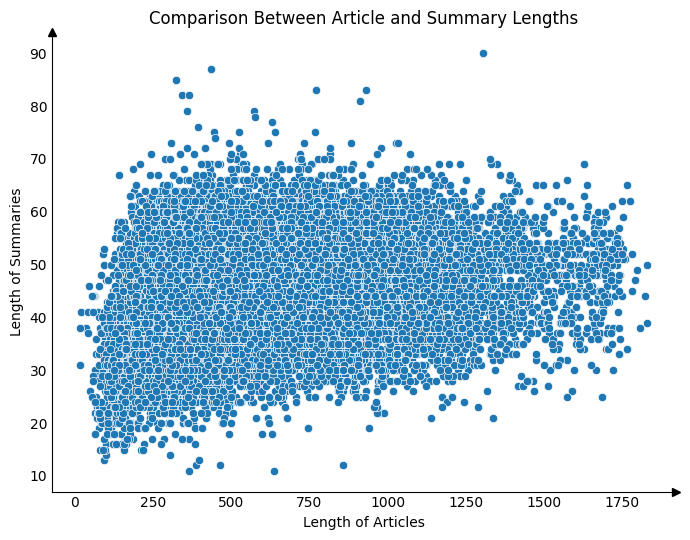

In [24]:
# Define object-oriented interface
fig, ax = plt.subplots(figsize=(7, 5.5))

scatter_word_counts = pd.DataFrame({"article": article_word_counts, "highlights": summary_word_counts["length"]})

sns.scatterplot(data=scatter_word_counts, x="article", y="highlights")
ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(length=0)

ax.spines[["right", "top"]].set_visible(False)

ax.plot(1, 0, ">k", transform=ax.transAxes, clip_on=False)
ax.plot(0, 1, "^k", transform=ax.transAxes, clip_on=False)

ax.set_title("Comparison Between Article and Summary Lengths")
ax.set_xlabel("Length of Articles")
ax.set_ylabel("Length of Summaries")

# Get ready to save the figure
fig.tight_layout()

## 10. Qualitative Analysis

In [25]:
with pd.option_context('display.max_colwidth', None):
  display(pd.DataFrame(dataset.select(range(2)))[["highlights", "article"]])

,highlights,article
0,Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have been held in trust fund .,"LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in ""Harry Potter and the Order of the Phoenix"" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. ""I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar,"" he told an Australian interviewer earlier this month. ""I don't think I'll be particularly extravagant. ""The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs."" At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film ""Hostel: Part II,"" currently six places below his number one movie on the UK box office chart. Details of how he'll mark his landmark birthday are under wraps. His agent and publicist had no comment on his plans. ""I'll definitely have some sort of party,"" he said in an interview. ""Hopefully none of you will be reading about it."" Radcliffe's earnings from the first five Potter films have been held in a trust fund which he has not been able to touch. Despite his growing fame and riches, the actor says he is keeping his feet firmly on the ground. ""People are always looking to say 'kid star goes off the rails,'"" he told reporters last month. ""But I try very hard not to go that way because it would be too easy for them."" His latest outing as the boy wizard in ""Harry Potter and the Order of the Phoenix"" is breaking records on both sides of the Atlantic and he will reprise the role in the last two films. Watch I-Reporter give her review of Potter's latest » . There is life beyond Potter, however. The Londoner has filmed a TV movie called ""My Boy Jack,"" about author Rudyard Kipling and his son, due for release later this year. He will also appear in ""December Boys,"" an Australian film about four boys who escape an orphanage. Earlier this year, he made his stage debut playing a tortured teenager in Peter Shaffer's ""Equus."" Meanwhile, he is braced for even closer media scrutiny now that he's legally an adult: ""I just think I'm going to be more sort of fair game,"" he told Reuters. E-mail to a friend . Copyright 2007 Reuters. All rights reserved.This material may not be published, broadcast, rewritten, or redistributed."
1,"Mentally ill inmates in Miami are housed on the ""forgotten floor""\nJudge Steven Leifman says most are there as a result of ""avoidable felonies""\nWhile CNN tours facility, patient shouts: ""I am the son of the president""\nLeifman says the system is unjust and he's fighting for change .","Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the ""forgotten floor,"" where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the ""forgotten floor."" Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually ""avoidable felonies."" He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems 

As we can see, the highlight sentence is a shorter and condensed version of the original text containing the key information.